# Document Rectifier

## Manual Mode

In [87]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from sklearn.cluster import KMeans

#### Import Test Images

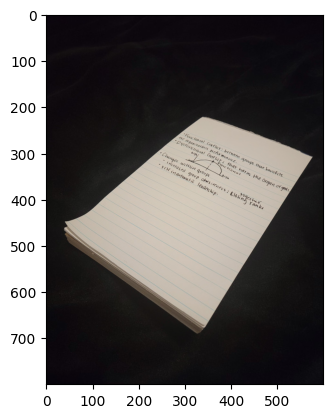

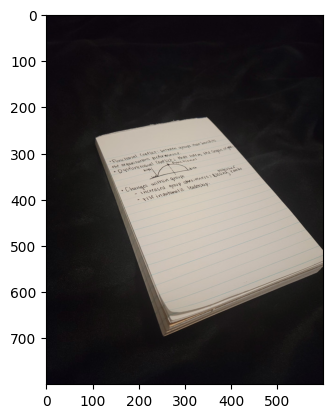

In [88]:
img1 = io.imread('https://i.postimg.cc/K8P2072J/rectify-image1.jpg')

plt.imshow(img1)
plt.show()

img2 = io.imread('https://i.postimg.cc/R0tX7GxZ/rectify-image2.jpg')
plt.imshow(img2)
plt.show()

### Corner input

In [89]:
# Recommended corner for img1
cornerA = "560, 314"
cornerB = "335, 666"
cornerC = "50, 460"
cornerD = "350, 220"

In [90]:
# Optional corner input mode (overwrites recommended)
# print("Enter corner coordinates as pairs: x, y\n")
# cornerA = input("A: ")
# cornerB = input("B: ")
# cornerC = input("C: ")
# cornerD = input("D: ")

In [91]:
# Split the input into x and y strings
corners = [cornerD, cornerC, cornerB, cornerA]
temp = []
for corner in corners:
    temp.append(corner.split(','))

# Evaluate the strings into coordinates
corners = []
for pair in temp:
    x, y = map(eval, pair)
    corners.append((x, y))


### Find the homography to map the image to the new space

In [92]:
# Determine output image width, height
width = 1000
height = 1500

# New positions for the transformed corners
newCorners = [(0,0), (0, height), (width, height), (width, 0)]

# Construct the matrix that solves p' = Hp and use SVD to get a solution
P = []
for i in range(4):
    x, y = corners[i][0], corners[i][1]
    u, v = newCorners[i][0], newCorners[i][1]
    P.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
    P.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])
P = np.asarray(P)
U, S, Vh = np.linalg.svd(P)
h = Vh[-1,:] / Vh[-1,-1]
H = h.reshape(3, 3)

# print(H)

### Perform the warping operation

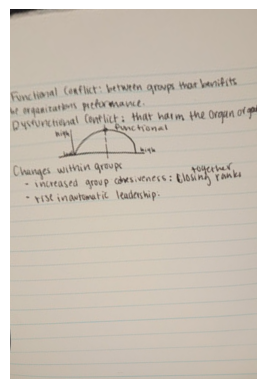

In [93]:
newImg = cv2.warpPerspective(img1, H, (width, height))
plt.imshow(newImg)
plt.axis('off')
plt.show()

## Fully automated document recovery

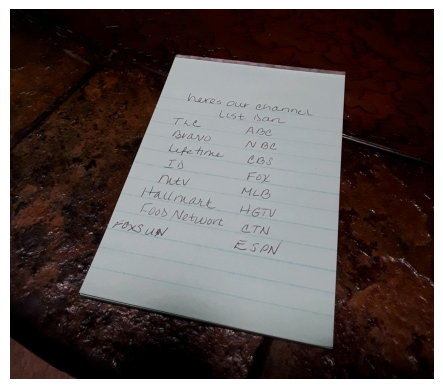

In [94]:
# Import test image
img = io.imread('https://i.redd.it/bebi64i3kbb31.jpg')
plt.axis('off')
plt.imshow(img)

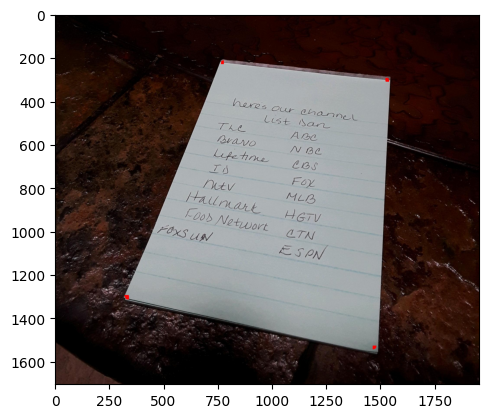

In [95]:
# Preprocess the image with intense blurring and binary thresholding
blur = cv2.GaussianBlur(img, (29,29), 21)

# View blurred image
# plt.imshow(blur)
# plt.show()

ret,threshold = cv2.threshold(blur, 120, 255, cv2.THRESH_BINARY)

# View thresholded image
# plt.imshow(threshold)
# plt.show()

grayscale = cv2.cvtColor(threshold, cv2.COLOR_BGR2GRAY)
grayscale = np.float32(grayscale)

# Apply Harris corner detection
detect = cv2.cornerHarris(grayscale, 21, 9, 0.05)

# For viewing purposes
img_copy = img.copy()
img_copy[detect>0.05*detect.max()]=[255,0,0]
plt.imshow(img_copy)

In [96]:
# Determine candidates for corners
detectedCorners = []
max = 0.05*detect.max()
for i in range(len(detect)):
  for j in range(len(detect[i])):
    if detect[i][j] > max:
      # fix reversed coordinates
      detectedCorners.append([j, i])

# Perform kmeans with 4 clusters to get 4 different positions of the corners
kmeans = KMeans(n_clusters=4, n_init=10).fit(detectedCorners)
indices = kmeans.cluster_centers_.astype('int')

In [97]:
# Order the points by angle to determine where each corner should be transformed to
indices = np.array(indices)
centroid = indices.mean(axis=0)

# Calculate the angles between each point and the center point
angles = np.arctan2(indices[:,1] - centroid[1], indices[:,0] - centroid[0])

# Sort the points based on their angles
sortedIndices = np.argsort(angles)
sortedCorners = indices[sortedIndices]

### Perform the same steps above with the newly detected corners

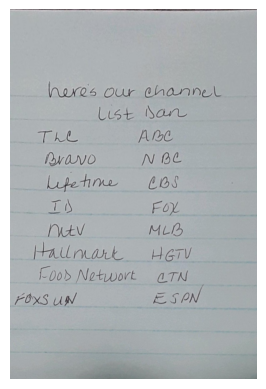

In [98]:
# Determine output image width, height
width = 1000
height = 1500

# New positions for the transformed corners
newCorners = [(0,0), (width, 0), (width, height), (0, height)]

# Construct the matrix that solves p' = Hp and use SVD to get a solution
P = []
for i in range(4):
    x, y = sortedCorners[i][0], sortedCorners[i][1]
    u, v = newCorners[i][0], newCorners[i][1]
    P.append([x, y, 1, 0, 0, 0, -u*x, -u*y, -u])
    P.append([0, 0, 0, x, y, 1, -v*x, -v*y, -v])
P = np.asarray(P)
U, S, Vh = np.linalg.svd(P)
h = Vh[-1,:] / Vh[-1,-1]
H = h.reshape(3, 3)

# Perform homography
newImg = cv2.warpPerspective(img, H, (width, height))
plt.imshow(newImg)
plt.axis('off')
plt.show()